In [1]:
using PyPlot

In [2]:
#We need an object that has two methods: the parameters, which are its location in parameter space
#and chi2 of the model calculated from the walker's position compared to the data
type walker
    params::Array{Float64}
    chi2::Float64
end

In [9]:
#This is an object that records a given walker's position and chi2 across multiple steps 
type walker_record
    walkers::Array{walker}
    nsteps::Int64
end
walker_record(ws::Array{walker}) = walker_record(ws,length(ws)) ;

In [8]:
#enter each walker's record as an element of an array, one entry for each walker
type walker_array
    recs::Array{walker_record}
    nwalkers::Int8
end
walker_array(recs::Array{walker_record}) = walker_array(recs,length(recs)) ;

In [7]:
#returns chi2 at a position in parameter space
chi2(f::Function,params::Array{Float64},data::Array{Float64,2}) = sum(((f(data[:,1],params).-data[:,2])./data[:,3]).^2) ;

In [6]:
#contains a model, f(x,p), number of parameters (length(p)), data (Nx3 Array), and how to 
# calculate a likelihood, chi(f,params,data). Defaults to chi2 if not specified
type ploglike 
    model::Function
    nparams::Int64
    data::Array{Float64,2}
    chi::Function
end
ploglike(func::Function,nparams::Int64,data::Array{Float64,2}) = ploglike(func,nparams,data,chi2) ;

#type model #contains a function, f(x,p), as well as nparams === length(p)
#    f::Function
#    nparams::Int8
#end

ploglike

In [25]:
#how to add a walker into a walker_record, and a walker_record into a walker_array,
#while keeping track of the number of steps taken/ the number of total walkers
import Base.push!
function push!(rec::walker_record,w::walker)
    push!(rec.walkers,w)
    rec.nsteps += 1
end
function push!(arr::walker_array,rec::walker_record)
    push!(arr.recs,rec)
    arr.nwalkers += 1
end ;

In [10]:
#Initialize a walker_array. nwalkers = nparams*3.0, nsteps=1, at the moment
function init_walkers(plog::ploglike,p0::Array{Float64},p_err::Array{Float64})
    nparam = plog.nparams
    nwalker = nparam*3.0
    chi_best = plog.chi(plog.model,p0,plog.data)
    w_array = walker_array(walker_record[])
    for j=1:nwalker
        chi_trial = 1.0e100
        par_trial = p0
        while chi_trial > (chi_best + 1000)
            par_trial = p0 + p_err.*randn(nparam)
            chi_trial = plog.chi(plog.model,par_trial,plog.data)
        end
        w = walker(par_trial,chi_trial)
        push!(w_array,walker_record([w]))
    end
    return w_array
end ;

In [33]:
function walk(w::walker,partner::walker,ascale::Float64,plog::ploglike)
    #Takes a walker and a partner, picks a new trial step based on parameters
    z=(rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
    par_trial = z.*w.params.+(1.0-z).*partner.params
    chi_like = plog.chi
    modl = plog.model
    # Compute chi-square:    
    chi_trial=chi_like(modl,par_trial,plog.data)
    alp = z^(plog.nparams-1.0)*exp(-0.5*(chi_trial - w.chi2)) #Assumes chi2 as well, needs to be generalized
    if alp >= rand()
        # If step is accepted, add it to the chains!
        accept = 1
        return (walker(par_trial,chi_trial),accept)
    else
        # Otherwise, copy the current walker
        accept = 0
        return (w,accept)
    end
end ;

In [34]:
function mcmc(plog::ploglike,p0::Array{Float64},p_err::Array{Float64},nstep::Int64)
    w_array = init_walkers(plog,p0,p_err)
    nparam = plog.nparams
    nwalker = w_array.nwalkers
    ascale = 2.0
    accept = 0
    for i=2:nstep
        #Like j = nwalkers, but now we can access the walkers directly!
        for (j,rec) in enumerate(w_array.recs)
            current_w = rec.walkers[end]
            ipartner = j
            while ipartner == j
                ipartner = ceil(Int,rand()*nwalker)
            end
            partner_w = w_array.recs[ipartner].walkers[end]
            # Now, make a trial walker
            (w,a) = walk(current_w,partner_w,ascale,plog)
            push!(rec,w)
            accept += a
        end
        if i%1000 == 0
            frac_acc = accept/(1000*nwalker)
            println("Number of steps: $i, acceptance rate: $frac_acc")
            ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
            accept = 0
        end
    end
    return w_array
end ;

In [35]:
get_history(w_array::walker_array,nwalk::Int64,p1::Int64,nstart::Int64) = [w.params[p1] for w in w_array.recs[nwalk].walkers[nstart:end]] ;

In [36]:
function get_median(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return median(plist)
end ;

In [37]:
function get_mean(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return mean(plist)
end ;

In [38]:
function get_std(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return std(plist)
end ;

In [39]:
function calc_iburn(w_array::walker_array)
    # Now, determine time of burn-in by calculating first time median is crossed:
    iburn = 0
    nparam = length(w_array.recs[1].walkers[1].params)
    nwalker = w_array.nwalkers
    nstep = w_array.recs[1].nsteps
    for i=1:nparam
        med_param=get_median(w_array,i,1)
        for rec in w_array.recs
            istep=2
            while (rec.walkers[istep].params[i] > med_param) == (rec.walkers[istep-1].params[i] > med_param) && (istep < nstep)
              istep=istep+1
            end
            if istep >= iburn
              iburn = istep
            end
        end
    end
    return iburn
end ;

In [40]:
function get_params(w_array::walker_array,iburn::Int64)
    nparam = length(w_array.recs[1].walkers[1].params)
    params = Float64[get_mean(w_array,i,iburn) for i=1:nparam]
    stds = Float64[get_std(w_array,i,iburn) for i=1:nparam]
    return params,stds
end ;

In [41]:
function plot_walkers(w_array::walker_array,p1::Int64,p2::Int64,nstart::Int64)
    pones = Float64[]
    ptwos = Float64[]
    for w=1:w_array.nwalkers
        append!(pones,get_history(w_array,w,p1,nstart))
        append!(ptwos,get_history(w_array,w,p2,nstart))
    end
    scatter(pones,ptwos)
end ;

In [42]:
function plot_trace(w_array::walker_array,p1::Int64,nstart::Int64)
    for w=1:w_array.nwalkers
        eyes = collect(1:w_array.recs[w].nsteps)
        vals = get_history(w_array,w,p1,nstart)
        plot(eyes,vals)
    end
    show()
end ;

In [43]:
function drop_the_mic(plog::ploglike,p0::Array{Float64},p_err::Array{Float64},nstep::Int64)
    final_walkers = mcmc(plog,p0,p_err,nstep)
    iburn = calc_iburn(final_walkers)
    vals,errs = get_params(final_walkers,iburn)
    for (val,err) in zip(vals,errs)
        println("$val +/- $err")
    end
    for i=2:plog.nparams
        for j=1:i-1
            plot_walkers(final_walkers,i,j,iburn)
            #show() #.jl file only
            clf()
        end
    end
    for i=1:plog.nparams
        plot_trace(final_walkers,i,1)
        #show() #.jl file only
        clf()
    end
end ;

Number of steps: 1000, acceptance rate: 0.6951666666666667
Number of steps: 2000, acceptance rate: 0.5
Number of steps: 3000, acceptance rate: 0.37366666666666665
Number of steps: 4000, acceptance rate: 0.30316666666666664
Number of steps: 5000, acceptance rate: 0.2895
Number of steps: 6000, acceptance rate: 0.2798333333333333
Number of steps: 7000, acceptance rate: 0.2465
Number of steps: 8000, acceptance rate: 0.25616666666666665
Number of steps: 9000, acceptance rate: 0.24266666666666667
Number of steps: 10000, acceptance rate: 0.25633333333333336


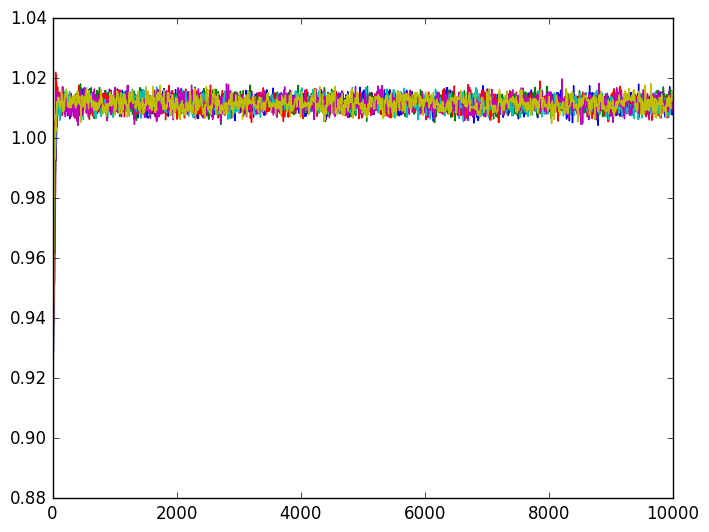

In [44]:
drop_the_mic(plog,p0,perr,10000)

In [45]:
mod_trial(x,p) = p[1].*x.+p[2]
xdata = collect(linspace(0,1,100))
ydata = mod_trial(xdata,[1.,1.])+rand(length(xdata))/10
yerr = rand(length(xdata))/10
data = hcat(xdata,ydata,yerr)
plog = ploglike(mod_trial,2,data)
p0 = [0.9,1.1]
perr = [0.01,0.01]
#foo = init_walkers(plog,p0,perr)
#for rec in foo.recs
#    push!(rec,walker([rand(),rand()],15.0))
#end
results = mcmc(plog,p0,perr,10000) ;
println("done")
#errorbar(xdata,ydata,yerr=yerr,fmt="xb")
#This gives a walker_array object to test the following out on if you so choose

1.0116250419694373 +/- 0.001979559768931797
1.0515131025376554 +/- 0.0013530041271035947
Number of steps: 1000, acceptance rate: 0.6836666666666666
Number of steps: 2000, acceptance rate: 0.5083333333333333
Number of steps: 3000, acceptance rate: 0.3631666666666667
Number of steps: 4000, acceptance rate: 0.32283333333333336
Number of steps: 5000, acceptance rate: 0.2786666666666667
Number of steps: 6000, acceptance rate: 0.2653333333333333
Number of steps: 7000, acceptance rate: 0.2608333333333333
Number of steps: 8000, acceptance rate: 0.2415
Number of steps: 9000, acceptance rate: 0.25866666666666666
Number of steps: 10000, acceptance rate: 0.258
done


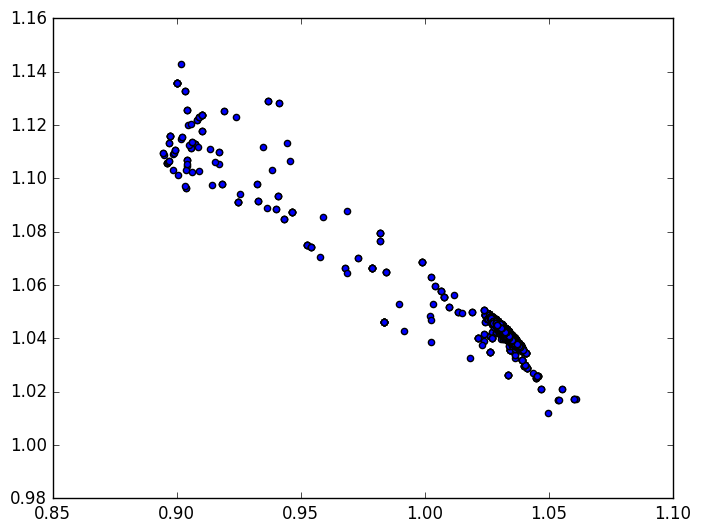

PyObject <matplotlib.collections.PathCollection object at 0x31f030a50>

In [46]:
plot_walkers(results,1,2,1)

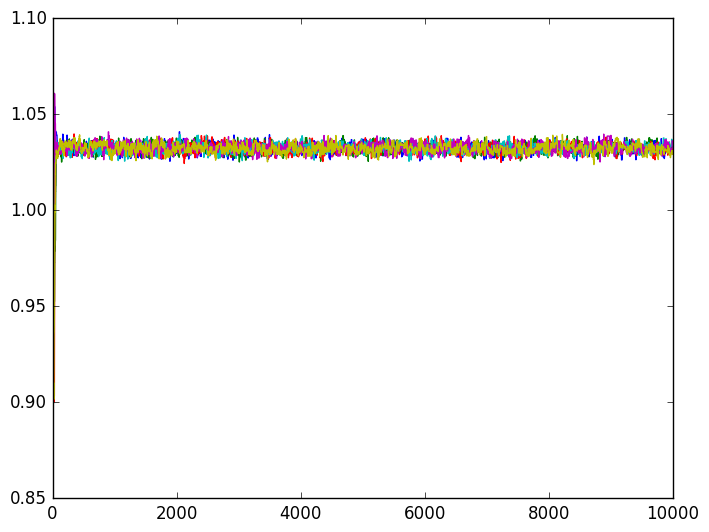

In [48]:
plot_trace(results,1,1)

# This is an attempt at generalizing the functionality of the "model" type into a "ploglike" type which contains a model, number of parameters, data and a chi^2-like function. When calculating whether to accept the step or not, needs work because it assumes it is chi^2.